# Семинар 4 - Интерполяция изображений, геометрия формирования изображения и калибровка камеры

***

**Данный семинар содержит домашнее задание - оцениваемые упражнения и вопросы.**

Система оценивания: доля правильно решенных упражений. Максимальный балл, соответственно, 1.

В упражнениях оценивается два аспекта:
1. Код проходит assert'ы (если они есть)
2. Код корректен с точки зрения логики

Вопросы также оцениваются. Ответ на них нужно записывать в соответствующие markdown-ячейки.

In [1]:
from pathlib import Path

import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Дополнительные материалы по теме семинара

- [YouTube: Resizing Images - Computerphile](https://youtu.be/AqscP7rc8_M?si=2l8fH_P_ghtzuFb7)
- [YouTube: Bicubic Interpolation - Computerphile](https://youtu.be/poY_nGzEEWM?si=G9W6mRjlsYPyyspN)
- [YouTube: Lanczos interpolation and resampling | Image processing](https://youtu.be/ijmd6XyG2HA?si=rIFwZSTUVVgrqo4I)
- [Interpolation Algorithms in PixInsight](https://pixinsight.com/doc/docs/InterpolationAlgorithms/InterpolationAlgorithms.html)


## Интерполяция изображений

![](data/interpolation.svg)


### Алгоритм пересчёта координат для масштабирования изображения

Данный алгоритм позволяет определить соответствие между пикселями нового и исходного изображений при масштабировании. Сначала вычисляются масштабные коэффициенты, затем для каждого пикселя нового изображения определяется соответствующая точка в исходном изображении. Это обеспечивает базу для применения методов интерполяции (nearest neighbor, bilinear, bicubic) с целью восстановления значений пикселей.

1. **Исходные данные:**

   - Исходное изображение: $W_{\text{orig}} \times H_{\text{orig}}$
   - Новое изображение: $W_{\text{new}} \times H_{\text{new}}$

2. **Вычисление масштабных коэффициентов:**

   $$k_x = \frac{W_{\text{orig}} - 1}{W_{\text{new}} - 1}, \quad k_y = \frac{H_{\text{orig}} - 1}{H_{\text{new}} - 1}$$

3. **Пересчёт координат:**

   - Для каждого пикселя нового изображения с координатами \((i, j)\) вычисляем координаты в исходном изображении:

     $$x = i \times k_x, \quad y = j \times k_y$$

4. **Применение интерполяции:**

   - **Nearest Neighbor:** округление до ближайшего целого значения.
   - **Bilinear:** использование четырёх ближайших пикселей с линейными весами.
   - **Bicubic:** использование 16 ближайших пикселей с кубическими весовыми функциями.

Такой алгоритм пересчета гарантирует, что угловые пиксели нового изображения будут соответствовать угловым пикселям исходного изображения.


### Интерполяция по ближайшему соседу (Nearest Neighbor)

**Формула:**

Для получения координат пикселя, ближайшего к вычисленным $(x, y)$, применяется функция округления:

$$x' = f_{\text{round}}(x), \quad y' = f_{\text{round}}(y)$$

Здесь:
- $(x, y)$ – координаты нового пикселя в исходном масштабе (как вычислено выше),
- $f_{\text{round}}()$ – функция округления, которая выбирает ближайший пиксель. В OpenCV для положительных значений применяется округление «в сторону ближе к 0» (то есть, функция $\text{floor}()$). Подробное рассмотрение влияния различных функций округления на интерполяцию по ближайшему соседу можно найти в статье: https://arxiv.org/abs/2003.06885.

**Принцип работы:**

Метод ближайшего соседа просто копирует значение ближайшего исходного пикселя. Это делает его быстрым, но приводит к характерным ступенчатым артефактам.

**Плюсы:**

- Высокая скорость выполнения.
- Полное сохранение резких границ в масках и бинарных изображениях.

**Минусы:**

- Грубые визуальные артефакты, особенно при увеличении.
- Потеря гладкости и непрерывности.

**Пример: Увеличение 3×3 → 6×6**

Исходное 3×3:

```
A B C
D E F
G H I
```

После увеличения (6×6):

```
A A B B C C
A A B B C C
D D E E F F
D D E E F F
G G H H I I
G G H H I I
```


#### Пример кода

В OpenCV интерполяция по ближайшему соседу реализуется функцией `cv2.resize()` с параметром интерполяции `cv2.INTER_NEAREST`.


a_letter.shape: (50, 50)


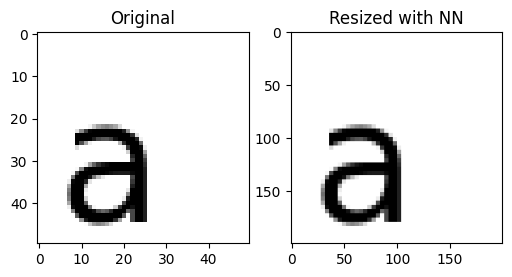

In [2]:
a_letter = cv2.imread('data/a_letter.png', cv2.IMREAD_GRAYSCALE)
print(f"a_letter.shape: {a_letter.shape}")

a_letter_resized_nn_opencv = cv2.resize(a_letter, (200, 200), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(a_letter, cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(a_letter_resized_nn_opencv, cmap='gray')
plt.title('Resized with NN')

plt.show()

#### Вопрос 1

_Этот и дальнейшие вопросы и упражнения будут оцениваться_

Что происходит при изменении размера в нецелое число раз? Дополните пример - как будет выглядеть "изображение" после увеличения до (5×5), если мы интерполируем его с помощью OpenCV?

**Ответ:**

Не все пиксели будут иметь одинаковое количество соответствующих им на измененной картинке. Например, можно видеть на примере 3*3 -> 5*5, что A имеет 4 соответствующих, а I - только один.

**Пример:**

Исходное 3×3:

```
A B C
D E F
G H I
```

После увеличения (5×5) с `cv2.INTER_NEAREST`:

```
A A B B C
A A B B C
D D E E F
D D E E F
G G H H I
```


#### Упражнение 1

Реализуйте функцию `resize_nearest_neighbor`, которая выполняет интерполяцию по ближайшему соседу. Функция принимает на вход исходное изображение и новый размер, а возвращает новое изображение. Сравнивайте результаты с функцией `cv2.resize` с параметром интерполяции `cv2.INTER_NEAREST`.

In [3]:
def resize_nearest_neighbor(img: np.ndarray, new_size: tuple[int]) -> np.ndarray:
    result = np.zeros(new_size, dtype=int)
    dx = img.shape[0] / new_size[0]
    dy = img.shape[1] / new_size[1]

    for i in range(new_size[0]):
        for j in range(new_size[1]):
            result[i, j] = img[int(i * dx), int(j * dy)]
    return result


In [4]:
sample = np.zeros((3, 3), dtype=np.uint8)
for x in range(3):
    for y in range(3):
        sample[x, y] = x * 10 + y
print("Исходное 3×3:")
print('\n'.join([' '.join([f'{item:02}' for item in row]) for row in sample]))

sample_resized_nn_opencv = cv2.resize(
    src=sample,
    dsize=(5, 5),
    interpolation=cv2.INTER_NEAREST,
)
print("\nПосле увеличения до 5×5 с помощью OpenCV:")
print('\n'.join([' '.join([f'{item:02}' for item in row]) for row in sample_resized_nn_opencv]))

sample_resized_nn_custom = resize_nearest_neighbor(sample, (5, 5))
print("\nПосле увеличения до 5×5 своей функцией:")
print('\n'.join([' '.join([f'{item:02}' for item in row]) for row in sample_resized_nn_custom]))

assert np.all(sample_resized_nn_opencv == sample_resized_nn_custom)


Исходное 3×3:
00 01 02
10 11 12
20 21 22

После увеличения до 5×5 с помощью OpenCV:
00 00 01 01 02
00 00 01 01 02
10 10 11 11 12
10 10 11 11 12
20 20 21 21 22

После увеличения до 5×5 своей функцией:
00 00 01 01 02
00 00 01 01 02
10 10 11 11 12
10 10 11 11 12
20 20 21 21 22


### Билинейная интерполяция (Bilinear Interpolation)

Билинейная интерполяция использует линейное взвешенное усреднение четырех ближайших пикселей, вычисляя значение нового пикселя как функцию их значений и расстояния до них. Это дает более плавные переходы по сравнению с методом ближайшего соседа.

**Пошаговый алгоритм:**

1. **Определение координат:**  

   Пусть необходимо вычислить значение пикселя в точке с координатами $(x, y)$, где $x$ и $y$ могут быть дробными. Определите ближайшие целочисленные координаты, ограничивающие эту точку:

   - $x_1 = \lfloor x \rfloor$ — наибольшее целое число, не превышающее $x$
   - $x_2 = x_1 + 1$
   - $y_1 = \lfloor y \rfloor$
   - $y_2 = y_1 + 1$

2. **Получение значений четырёх соседних пикселей:**

   Обозначим значение пикселя в точке $(i, j)$ как $f(i, j)$. Тогда:

   - $f(x_1, y_1)$ — верхний левый пиксель
   - $f(x_2, y_1)$ — верхний правый пиксель
   - $f(x_1, y_2)$ — нижний левый пиксель
   - $f(x_2, y_2)$ — нижний правый пиксель

3. **Линейная интерполяция по оси $x$:**

   Вычисляем промежуточные значения для двух строк:

   - Для $y = y_1$:

     $$f_{y1}(x) = f(x_1, y_1) \cdot (x_2 - x) + f(x_2, y_1) \cdot (x - x_1)$$

   - Для $y = y_2$:

     $$f_{y2}(x) = f(x_1, y_2) \cdot (x_2 - x) + f(x_2, y_2) \cdot (x - x_1)$$


4. **Линейная интерполяция по оси $y$:**  

   Интерполируем между $f_{y1}(x)$ и $f_{y2}(x)$ по оси $y$:

   $$f(x, y) = f_{y1}(x) \cdot (y_2 - y) + f_{y2}(x) \cdot (y - y_1)$$

5. **Нормировка (при необходимости):**  

   Если разницы $x_2 - x_1$ и $y_2 - y_1$ не равны 1, итоговая формула может включать деление на $(x_2 - x_1)(y_2 - y_1)$.

   В стандартной ситуации для изображений, где пиксели располагаются через один и тот же интервал (то есть $x_2 - x_1 = 1$ и $y_2 - y_1 = 1$), нормировка не требуется, так как знаменатель равен 1.

**Итоговая формула:**

Объединяя шаги, получаем:

$$f(x, y) = f(x_1, y_1)(x_2 - x)(y_2 - y) + f(x_2, y_1)(x - x_1)(y_2 - y) + f(x_1, y_2)(x_2 - x)(y - y_1) + f(x_2, y_2)(x - x_1)(y - y_1)$$

> **Примечание:** знаменатель $(x_2 - x_1)(y_2 - y_1)$ здесь опущен, так как в случае изображений он равен 1.

**Плюсы:**

- Более гладкие градиенты и отсутствие резких артефактов.
- Умеренная вычислительная сложность.

**Минусы:**

- Размытость границ, особенно в высококонтрастных участках.
- Не учитывает сложные изменения в структуре изображения.

**Пример: Увеличение 3×3 → 6×6**

Исходное 3×3:

```
10 20 30
40 50 60
70 80 90
```

После увеличения (6×6) с билинейной интерполяцией:

```
10 14 18 22 26 30
22 26 30 34 38 42
34 38 42 46 50 54
46 50 54 58 62 66
58 62 66 70 74 78
70 74 78 82 86 90
```

Каждый новый пиксель получает значение, рассчитанное на основе билинейного взвешенного усреднения четырех ближайших соседних значений, что приводит к более плавным переходам между исходными значениями.


#### Пример кода

В OpenCV билинейная интерполяция соответствует методу `cv2.INTER_LINEAR`.


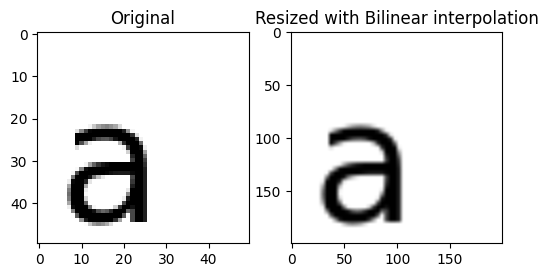

In [5]:
a_letter_resized_bilinear_opencv = cv2.resize(
    a_letter,
    (200, 200),
    interpolation=cv2.INTER_LINEAR,
)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(a_letter, cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(a_letter_resized_bilinear_opencv, cmap='gray')
plt.title('Resized with Bilinear interpolation')

plt.show()

#### Упражнение 2

Реализуйте функцию `resize_bilinear_interpolation` для билинейной интерполяции изображения. Функция должна принимать на вход исходное изображение и размер нового изображения, а возвращать новое изображение, интерполированное методом билинейной интерполяции.


In [ ]:
def resize_bilinear_interpolation(img: np.ndarray, new_size: tuple[int]) -> np.ndarray:
    result = np.zeros(new_size, dtype=int)
    dx = (img.shape[0] - 1) / (new_size[0] - 1)
    dy = (img.shape[1] - 1) / (new_size[1] - 1)

    for i in range(new_size[0]):
        for j in range(new_size[1]):
            x0 = i * dx
            y0 = j * dy
            x1 = int(x0)
            y1 = int(y0)
            x2 = x1 + 1
            y2 = y1 + 1
            y2 = min(y2, img.shape[1] - 1)
            x2 = min(x2, img.shape[0] - 1)
            dx1 = x0 - x1
            dx2 = y0 - y1
            t1 = (1 - dx2) * img[x1, y1] + dx2 * img[x1, y2]
            t2 = (1 - dx2) * img[x2, y1] + dx2 * img[x2, y2]
            result[i, j] = (1 - dx1) * t1 + dx1 * t2
    return result


In [40]:
sample = np.arange(1, 10, dtype=np.uint8).reshape(3, 3) * 10
print("\nИсходное 3×3:")
print(sample)

sample_resized_1 = resize_bilinear_interpolation(sample, (6, 6))
print("\nПосле увеличения до 6×6 c помощью своей функции:")
print(sample_resized_1)

sample_resized_2 = cv2.resize(
    src=sample,
    dsize=(6, 6),
    interpolation=cv2.INTER_LINEAR,
)
print("\nПосле увеличения до 6×6 c помощью OpenCV:")
print(sample_resized_2)



Исходное 3×3:
[[10 20 30]
 [40 50 60]
 [70 80 90]]

После увеличения до 6×6 c помощью своей функции:
[[10 14 18 22 26 30]
 [22 26 30 34 38 42]
 [34 38 42 46 50 54]
 [46 50 54 58 62 66]
 [58 62 66 70 74 78]
 [70 74 78 82 86 90]]

После увеличения до 6×6 c помощью OpenCV:
[[10 12 17 22 27 30]
 [18 20 25 30 35 38]
 [33 35 40 45 50 53]
 [48 50 55 60 65 68]
 [63 65 70 75 80 83]
 [70 72 77 82 87 90]]


### Бикубическая интерполяция (Bicubic Interpolation)

Бикубическая интерполяция идёт дальше билинейной, используя **16 ближайших пикселей** (по 4 вдоль каждой оси). Вместо простой линейной аппроксимации здесь используется **кубическая** функция, что даёт более плавные переходы и, зачастую, лучшее качество в плавных градиентах. Однако метод сложнее в вычислительном плане и может создавать артефакты (гало-эффекты) вокруг резких границ.

1. **Определение координат**  

   Как и в билинейной интерполяции, сначала нужно вычислить, какие координаты в исходном изображении соответствуют точке $(x, y)$ в новом изображении (с учётом масштабных коэффициентов). Пусть
   $$
   x = i \cdot k_x, \quad y = j \cdot k_y,
   $$

   где $k_x$ и $k_y$ — масштабные коэффициенты, а $(i, j)$ — координаты пикселя в результирующем изображении.

2. **Выбор 16 соседних пикселей**  
   
   Пусть $\lfloor x \rfloor = x_1$ и $\lfloor y \rfloor = y_1$. Тогда набор координат выглядит так:

   - $(x_1 - 1,\; y_1 - 1)$, $(x_1,\; y_1 - 1)$, $(x_1 + 1,\; y_1 - 1)$, $(x_1 + 2,\; y_1 - 1)$
   - $(x_1 - 1,\; y_1)$,   $(x_1,\; y_1)$,   $(x_1 + 1,\; y_1)$,   $(x_1 + 2,\; y_1)$
   - $(x_1 - 1,\; y_1 + 1)$, $(x_1,\; y_1 + 1)$, $(x_1 + 1,\; y_1 + 1)$, $(x_1 + 2,\; y_1 + 1)$
   - $(x_1 - 1,\; y_1 + 2)$, $(x_1,\; y_1 + 2)$, $(x_1 + 1,\; y_1 + 2)$, $(x_1 + 2,\; y_1 + 2)$

   Всего получается 16 значений пикселей исходного изображения, влияющих на значение точки $(x, y)$.

3. **Кубическая интерполяция по одной из осей (например, по $x$)**  
   
   Для каждой из четырёх строк (фиксированного $y_n$) выполняют **одномерную кубическую интерполяцию** по оси $x$. Результатом становятся 4 промежуточных значения — по одному для каждой строки.

4. **Кубическая интерполяция по другой оси (по $y$)**  
   
   Полученные 4 промежуточных значения снова интерполируются между собой **кубической функцией**, но уже по оси $y$. Итог — одно число: интенсивность (или цвет) нового пикселя $(x, y)$.

5. **Использование кубического ядра**  
   
   На практике часто применяют **форму кубического сплайн-ядра** вида:
   
   $$
   w(t) = 
   \begin{cases}
     (a+2)|t|^3 - (a+3)|t|^2 + 1, & |t| \le 1 \\
     a|t|^3 - 5a|t|^2 + 8a|t| - 4a, & 1 < |t| \le 2 \\
     0, & |t| > 2
   \end{cases}
   $$
   
   где $a$ (обычно $-0.5$) задаёт форму кривой. Такое ядро применяют отдельно по осям $x$ и $y$, сворачивая значения 16 пикселей с соответствующими весовыми коэффициентами.

**Итоговая формула:**

В свёрточном виде бикубическая интерполяция может быть записана так:

$$
f(x, y) = \sum_{m=-1}^{2} \sum_{n=-1}^{2} f(x_1 + m,\; y_1 + n)\; w(m - dx)\; w(n - dy),
$$

где:

- $x_1 = \lfloor x \rfloor$, $\; y_1 = \lfloor y \rfloor$,
- $dx = x - x_1$, $\; dy = y - y_1$,
- $w(\cdot)$ — указанное выше **кубическое сплайн-ядро**,
- $f(i, j)$ — значение пикселя в точке $(i, j)$ исходного изображения.

**Плюсы:**

- Даёт превосходные результаты для плавных градиентов и текстур.
- Часто выглядит “профессиональнее” при увеличении.

**Минусы:**

- Вычислительно дороже, чем билинейная и ближайший сосед.
- Может вызывать [эффект гало](https://ru.wikipedia.org/wiki/Гало) и “звон” на резких границах.


**Пример: Увеличение 4×4 → 8×8**

Исходное 4×4:

```
 10  20  30  40
 50  60  70  80
 90 100 110 120
130 140 150 160
```

После увеличения (8×8) с бикубической интерполяцией (ядро $a = -0.5$):

```
 10  14  18  23  28  33  38  40
 30  36  42  48  55  61  66  68
 50  56  63  70  78  85  90  92
 71  77  84  91  99 106 111 113
 91  98 105 112 120 127 133 136
111 119 126 134 142 149 155 158
131 139 147 155 163 170 176 179
130 137 144 152 159 166 172 160
```

(Значения приблизительны и приведены для иллюстрации. Реальные числа зависят от точного ядра и точности вычислений.)

Таким образом, бикубическая интерполяция даёт **более плавные** переходы среди классических методов, но требует больших вычислительных затрат и может вносить нежелательные артефакты на резких границах.

#### Пример кода

В OpenCV бикубическая интерполяция соответствует методу `cv2.INTER_CUBIC`.


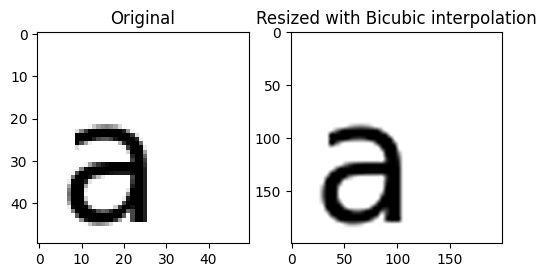

In [41]:
a_letter_resized_bicubic_opencv = cv2.resize(
    a_letter,
    (200, 200),
    interpolation=cv2.INTER_CUBIC,
)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(a_letter, cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(a_letter_resized_bicubic_opencv, cmap='gray')
plt.title('Resized with Bicubic interpolation')

plt.show()

#### Эффект гало

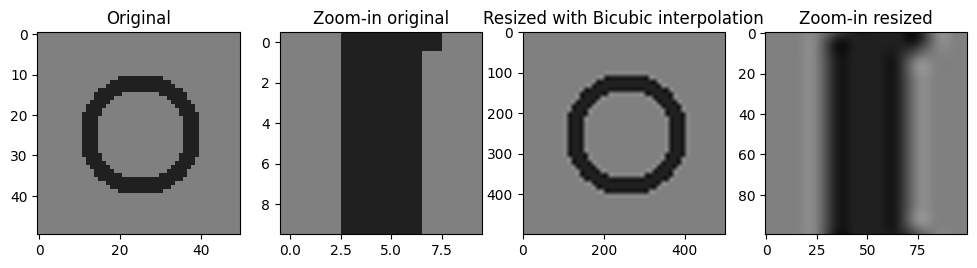

In [42]:
size = 50
background_color = 128  # светло-серый фон
border_color = 32       # более тёмный оттенок
radius_1 = 15
radius_2 = 11
center = (size // 2, size // 2)  # Координаты центра

# Создаем 50x50 изображение, заполненное фоновым цветом
ring_img = np.full((size, size), background_color, dtype=np.uint8)

# Рисуем кольцо
for y in range(size):
    for x in range(size):
        dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)
        if dist < radius_1 and dist >= radius_2:
            ring_img[y, x] = border_color

ring_img_resized_bicubic_opencv = cv2.resize(
    ring_img,
    (500, 500),
    interpolation=cv2.INTER_CUBIC,
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(ring_img, cmap='gray',vmin=0, vmax=255)
plt.title('Original')

plt.subplot(1, 4, 2)
plt.imshow(ring_img[20:30, 8:18], cmap='gray',vmin=0, vmax=255)
plt.title('Zoom-in original')

plt.subplot(1, 4, 3)
plt.imshow(ring_img_resized_bicubic_opencv, cmap='gray', vmin=0, vmax=255)
plt.title('Resized with Bicubic interpolation')

plt.subplot(1, 4, 4)
plt.imshow(ring_img_resized_bicubic_opencv[200:300, 80:180], cmap='gray', vmin=0, vmax=255)
plt.title('Zoom-in resized')

plt.show()

#### Вопрос 2

Как влияет выбор параметра $a$ в формуле кубического сплайн-ядра (например, $a=−0.5,−0.75,−1.0$) на итоговое качество бикубической интерполяции (эффект гало, степень размытия, резкость границ)? Существует ли оптимальный выбор $a$, уравновешивающий гало-артефакты и степень сглаживания?

**Ответ:**

a = -0.5 - компромиссный вариант, в котором умеренный эффект гало и резкость.
При a = -0.75 и -1.0 границы становятся более резкими, но так же повышает и эффект гало.

## Другие методы интерполяции

### **Area (Интерполяция по площади)**

**Идея**

Для каждого нового пикселя определяется та часть (проекция) в исходном изображении, которая ему соответствует. Далее берется **среднее значение** (либо взвешенное, если проекция пересекает несколько пикселей частично) всей этой области.

**Как определяется “проекция”?**

1. Допустим, мы знаем масштабный коэффициент (по $x$ и $y$).  
2. Для пикселя $(i, j)$ в новом изображении вычисляется соответствующая область $[x_{\text{min}},\, x_{\text{max}}) \times [y_{\text{min}},\, y_{\text{max}})$ в старом изображении.  
3. Все пиксели старого изображения, которые частично или полностью лежат в этой области, учитываются при усреднении. Если пиксель пересекается не полностью, учитывается только доля площади пересечения.

**Применение**  

- **Наиболее эффективно** при **уменьшении** (downsampling), так как такое “интегрирование” позволяет избежать артефактов передискретизации (aliasing).  
- При увеличении (upsampling) визуальный результат обычно хуже, чем у билинейной, бикубической или Lanczos.  
- В OpenCV вызывается методом `cv2.INTER_AREA`.

### **Lanczos (Ланцош-фильтр)**

**Идея**  

Lanczos — это **свёртка** с окном (windowed) **sinc-функции**. Функция $\text{sinc}(x)$ обычно определяется как:

$$
\text{sinc}(x) = 
\begin{cases}
\frac{\sin(\pi x)}{\pi x}, & x \ne 0,\\
1, & x=0.
\end{cases}
$$

Вместо бесконечного sinc используют окно (то есть “обрезают” её), чтобы фильтр был конечной длины. Количество “лепестков” (lobes) за пределами центрального пика определяет порядок Lanczos:  

- Lanczos2 — два “лепестка” в каждую сторону,  
- Lanczos3 — три и т. д.

Тогда функция **Lanczos** определяется следующим образом:

$$
L(x; n > 0) =
\begin{cases}
\text{sinc}(x) \cdot \text{sinc}(x/n), & |x| \le n, \\
0, & |x| > n.
\end{cases}
$$

**Что такое “лепестки” (lobes)?**  

На графике $\sin(\pi x)/(\pi x)$ после центрального пика видны волнообразные “отрицательные” и “положительные” колебания (их называют лепестками, или lobes). Чем дальше мы отходим от нуля, тем меньше “вес” пикселя, но тем более “расширенной” становится поддержка фильтра.

**Применение**  

- Lanczos даёт **высокое качество** при увеличении и уменьшении, часто превосходя бикубический метод для плавных градиентов и детальных текстур.  
- Может создавать **“звон” (ringing artifacts)** вокруг резких переходов, так как sinc-функция имеет волновую природу и не “загрублена” вблизи обрывов.  
- В OpenCV реализован как `cv2.INTER_LANCZOS4` (четыре лепестка).

**График функции Lanczos4**

![lanczos4_func](./data/Lanczos4FunctionGraph.svg)


#### Упражнение 3

Реализуйте функцию `resize_lanczos` для интерполяции методом Ланцоша. Функция должна принимать на вход исходное изображение и размер нового изображения, а возвращать новое изображение, интерполированное методом Ланцоша.


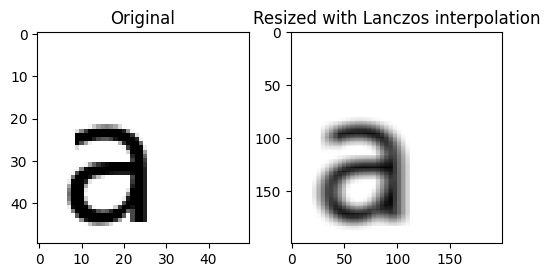

In [52]:
def lanczos_kernel(x, y, a) -> np.ndarray:
    return np.where(np.abs(x) < a, np.sinc(x / np.pi) * np.sinc(x / a / np.pi), 0)


def resize_lanczos(img: np.ndarray, new_size: tuple[int, int], a: int = 4) -> np.ndarray:
    result = np.zeros(new_size, dtype=int)
    dx = img.shape[0] / new_size[0]
    dy = img.shape[1] / new_size[1]

    for i in range(new_size[0]):
        for j in range(new_size[1]):
            x0 = i * dx
            y0 = j * dy

            x_l = int(x0) - a
            x_r = int(x0) + a + 1
            y_l = int(y0) - a
            y_r = int(y0) + a + 1
            w = 0
            pixel_value = 0.0
            for x in range(x_l, x_r):
                for y in range(y_l, y_r):
                    if x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[1]:
                        w += lanczos_kernel(x - x0, y - y0, a)
                        result[i,j] += lanczos_kernel(x - x0, y - y0, a) * img[x, y]
            if (w > 0):
                result[i, j] = result[i, j] / w

    return result


# Применяем интерполяцию Lanczos
a_letter_resized_lanczos_custom = resize_lanczos(a_letter, (200, 200), a=2)

# Визуализация результата
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(a_letter, cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(a_letter_resized_lanczos_custom, cmap='gray')
plt.title('Resized with Lanczos interpolation')

plt.show()


## Сравнение методов в OpenCV

Согласно [документации OpenCV](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html) для **сжатия изображения** — наиболее предпочтительным методом интерполяции является `cv.INTER_AREA`,
**для увеличения изображения** — наиболее предпочтительны методы интерполяции: `cv.INTER_CUBIC` (медленный) и `cv.INTER_LINEAR`.

In [53]:
interpolation_algorithm = [
    ("nearest", cv2.INTER_NEAREST),
    ("bilinear", cv2.INTER_LINEAR),
    ("bicubic", cv2.INTER_CUBIC),
    ("area", cv2.INTER_AREA),
    ("lanczos4", cv2.INTER_LANCZOS4)
]

def resize_by_factor(
    img: np.array,
    factor: float,
) -> None:

    height, width = img.shape[:2]
    height2, width2 = int(height*factor), int(width*factor)

    print(f'orig size: h={height}, w={width}, resised size: h={height2}, w={width2}')

    fig, axes = plt.subplots(
        nrows=len(interpolation_algorithm),
        sharex=True,
        sharey=True,
        figsize=(3, 20)
    )

    imgs = []
    for i in range(len(interpolation_algorithm)):

        img_resized = cv2.resize(
            src=img,
            dsize=(width2, height2),
            interpolation=interpolation_algorithm[i][1],
        )

        axes[i].imshow(img_resized, cmap='Greys_r')
        axes[i].set_title(
            f"{interpolation_algorithm[i][0]}, shape = {img_resized.shape}",
        )

### Оригинальное изображение

Text(0.5, 1.0, 'Original image, shape = (50, 50)')

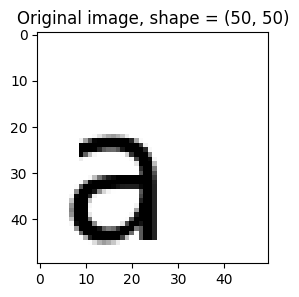

In [54]:
IMG_PATH = "data/a_letter.png"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_04/data .

a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(3, 3))
plt.imshow(a_letter_img, cmap="Greys_r")
plt.title(f"Original image, shape = {a_letter_img.shape}")

### Увеличение

orig size: h=50, w=50, resised size: h=250, w=250


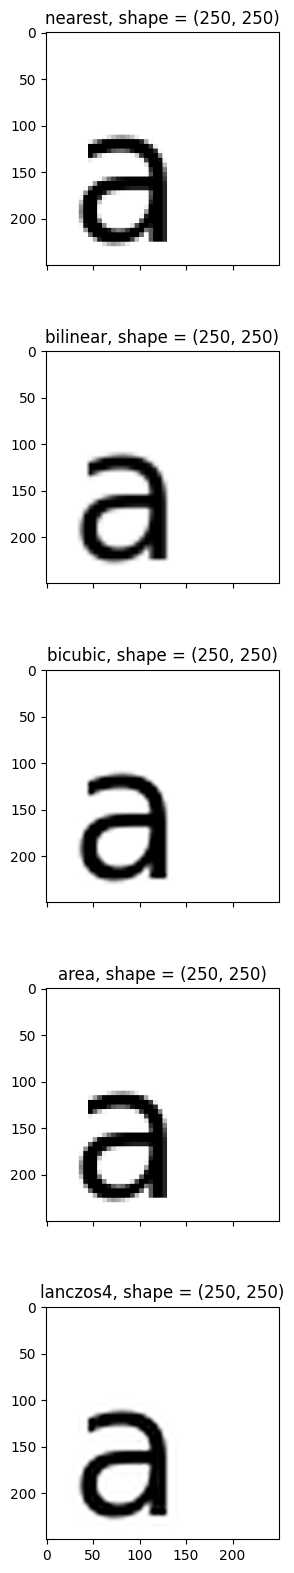

In [55]:
resize_by_factor(
    img=a_letter_img,
    factor=5,
)

### Уменьшение

orig size: h=50, w=50, resised size: h=25, w=25


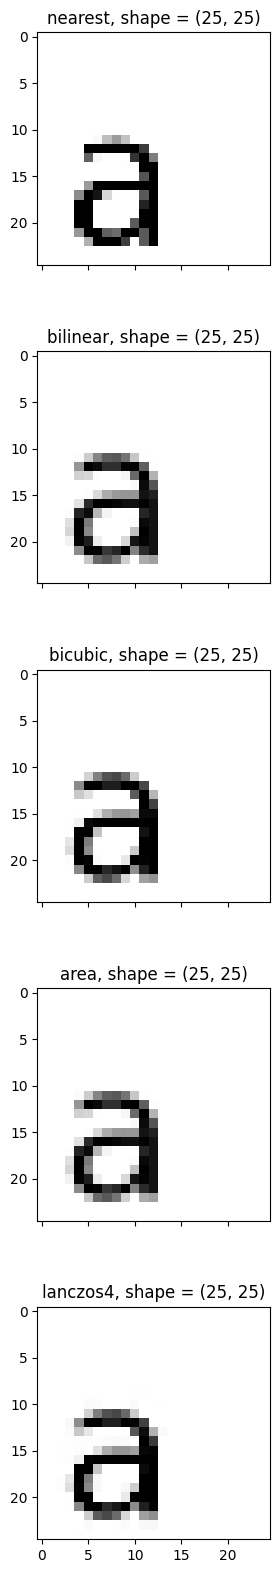

In [56]:
resize_by_factor(
    img=a_letter_img,
    factor=0.5,
)

## Упражение 3

Можно ли реализовать функцию уменьшения изображения, используя свёртки?
Напишите такую функцию, которая уменьшает изображение в N раз, применяя свёрточный фильтр усреднения перед выборкой.

**Подсказка:**

- Используйте размывающий фильтр (например, ядро усреднения)
- Используйте стандартный оператор свёртки (`cv2.filter2D`)


TypeError: Image data of dtype object cannot be converted to float

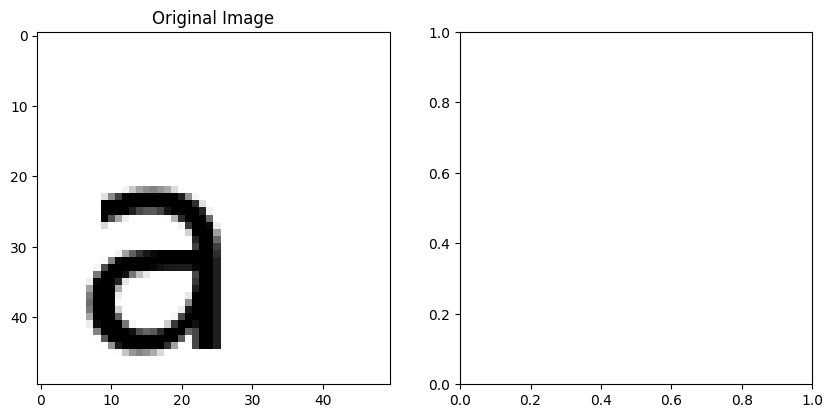

In [57]:
def downsample_with_convolution(img: np.ndarray, scale_factor: int) -> np.ndarray:
    """
    Downsamples an image using convolution before subsampling.

    Args:
        img (np.ndarray): Input image.
        scale_factor (int): Factor by which to downsample the image (must be >= 2).

    Returns:
        np.ndarray: Downsampled image.

    Raises:
        ValueError: If scale_factor is less than 2.
    """
    if scale_factor < 2:
        raise ValueError("Scale factor must be >= 2")

    pass


a_letter_downsampled_convolution = downsample_with_convolution(a_letter, 2)

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(a_letter, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(a_letter_downsampled_convolution, cmap='gray')
plt.title("Downsampled Image (x2)")

plt.show()


## Трансформация изображений

[Туториал OpenCV "Geometric Transformations of Images"](https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html)

### Поворот (Rotation)

Входные параметры: угол поворота (angle)

```python
matrix = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
])
```

Формула поворота:
$$
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} =
\begin{bmatrix} \cos(\theta) & -\sin(\theta) & 0 \\
                 \sin(\theta) & \cos(\theta) & 0 \\
                 0 & 0 & 1 \end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

### Растяжение/сжатие (Scale)

Входные параметры: фактор растяжения (sx, sy)

```python
matrix = np.array([
      [s[0], 0,    0],
      [0,    s[1], 0],
      [0,    0,    1],
])
```

Формула масштабирования:
$$
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} =
\begin{bmatrix} s_x & 0 & 0 \\
                 0 & s_y & 0 \\
                 0 & 0 & 1 \end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

### Перенос (translation)

Входные параметры: фактор переноса (tx, ty)

```python
matrix = np.array([
      [1,  0, t[0]],
      [0,  1, t[1]],
      [0,  0,    1],
])
```

Формула переноса:
$$
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} =
\begin{bmatrix} 1 & 0 & t_x \\
                 0 & 1 & t_y \\
                 0 & 0 & 1 \end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

### Сдвиг (shearing)

Входные параметры: фактор сдвига (kx, ky)

```python
matrix_horisontal = np.array([
      [1,    k[0], 0],
      [k[1], 1,    0],
      [0,    0,    1],
])
```

Формула сдвига:
$$
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} =
\begin{bmatrix} 1 & k_x & 0 \\
                 k_y & 1 & 0 \\
                 0 & 0 & 1 \end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

### Типы трансформаций по степеням свободы

![image_transformations](data/image_transformations.png)

_Источник - [Computer Vision: Algorithms and Applications, 2nd ed. 2022 Richard Szeliski](https://szeliski.org/Book/)_

#### Translation (Перенос)
- Использует **2 параметра**: \(t_x, t_y\).
- Сдвигает изображение без изменения формы.

#### Euclidean (Rigid) (Евклидовы преобразования)
- Использует **3 параметра**: угол поворота \(\theta\) и сдвиги \(t_x, t_y\).
- Сохраняет расстояния между точками, запрещая масштабирование и деформации.
- Матрица вида:
  $$
  \begin{bmatrix} \cos(\theta) & -\sin(\theta) & t_x \\
                   \sin(\theta) & \cos(\theta) & t_y \\
                   0 & 0 & 1 \end{bmatrix}
  $$

#### Similarity (Подобие)
- Использует **4 параметра**: поворот \(\theta\), масштабирование \(s\), сдвиги \(t_x, t_y\).
- Сохраняет пропорции, но допускает изменение масштаба.
- Матрица:
  $$
  \begin{bmatrix} s \cos(\theta) & -s \sin(\theta) & t_x \\
                   s \sin(\theta) & s \cos(\theta) & t_y \\
                   0 & 0 & 1 \end{bmatrix}
  $$

#### Affine (Афинные преобразования)
- Использует **6 параметров**: два столбца (2D-базис), сдвиг.
- Сохраняет параллельность линий, но допускает масштабирование, поворот и сдвиг.
- Матрица:
  $$
  \begin{bmatrix} a_{11} & a_{12} & t_x \\
                   a_{21} & a_{22} & t_y \\
                   0 & 0 & 1 \end{bmatrix}
  $$

#### Projective (Проективные преобразования)
- Использует **8 параметров**, включая перспективные искажения.
- Позволяет менять точки схода (например, для перспективного искажения).
- Матрица:
  $$
  \begin{bmatrix} a_{11} & a_{12} & t_x \\
                   a_{21} & a_{22} & t_y \\
                   p_1 & p_2 & 1 \end{bmatrix}
  $$
- Используется в задачах **перспективного выравнивания**.


### Упражнение 4

Реализуйте функцию, которая принимает изображение и матрицу преобразования, и реализует афинную трансформацию. Функция должна возвращать новое изображение после преобразования.


In [64]:
def make_rotation(params: list[float]) -> np.ndarray:
    """
    Creates a rotation matrix.

    Args:
        params (list[float]): [angle in radians]

    Returns:
        np.ndarray: 3x3 rotation matrix
    """
    angle = params[0]
    mat = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

    return mat

def make_scaling(params: list[float]) -> np.ndarray:
    """
    Creates a scaling matrix.

    Args:
        params (list[float]): [scaling factor for X, scaling factor for Y]

    Returns:
        np.ndarray: 3x3 scaling matrix
    """
    sx, sy = params[0], params[1]

    mat = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])

    return mat

def make_translation(params: list[float]) -> np.ndarray:
    """
    Creates a translation matrix.

    Args:
        params (list[float]): [translation in X, translation in Y]

    Returns:
        np.ndarray: 3x3 translation matrix
    """
    tx, ty = params[0], params[1]

    mat = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ], dtype=np.float32)


    return mat

def make_shearing(params: list[float]) -> np.ndarray:
    """
    Creates a shearing matrix.

    Args:
        params (list[float]): [shearing factor for X, shearing factor for Y]

    Returns:
        np.ndarray: 3x3 shearing matrix
    """
    shx, shy = params[0], params[1]

    mat = np.array([
        [1, shx, 0],
        [shy, 1, 0],
        [0, 0,  1]
    ])


    return mat

def affine_transform(img: np.ndarray, mat: np.ndarray) -> np.ndarray:
    """
    Applies an affine transformation to an image.

    Args:
        img (np.ndarray): Input image (numpy array)
        mat (np.ndarray): 3x3 transformation matrix

    Returns:
        np.ndarray: Transformed image
    """
    return cv2.warpAffine(img, mat[:2, :], (img.shape[1], img.shape[0]))


Проверьте код на примере изображения c астронавтом, запустите все 4 преобразования:

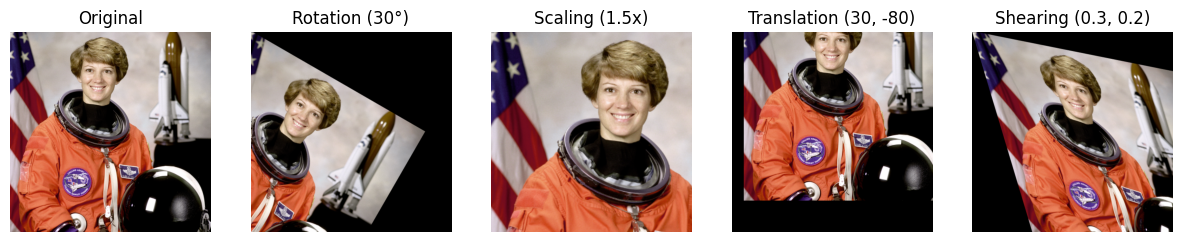

In [65]:
astonaut_img = skimage.data.astronaut()

rotation_matrix = make_rotation([np.radians(30)])
scaling_matrix = make_scaling([1.5, 1.5])
translation_matrix = make_translation([30, -80])
shearing_matrix = make_shearing([0.3, 0.2])

# Трансформированные изображения
astonaut_rotated_img = affine_transform(astonaut_img, rotation_matrix)
astonaut_scaled_img = affine_transform(astonaut_img, scaling_matrix)
astonaut_translated_img = affine_transform(astonaut_img, translation_matrix)
astonaut_sheared_img = affine_transform(astonaut_img, shearing_matrix)

# Визуализация всех трансформаций
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

titles = ["Original", "Rotation (30°)", "Scaling (1.5x)", "Translation (30, -80)", "Shearing (0.3, 0.2)"]
images = [astonaut_img, astonaut_rotated_img, astonaut_scaled_img, astonaut_translated_img, astonaut_sheared_img]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis("off")

plt.show()

### Упражнение 5 - Картина "Послы" Ганса Гольбейна Младшего (1533)

Картина "Послы" (1533) — произведение немецкого художника Ганса Гольбейна Младшего. На ней изображены два аристократа, а в нижней части композиции — искажённый череп. Этот эффект достигается с помощью анаморфозы — техники перспективного искажения, которое можно исправить, если рассчитать правильное аффинное преобразование.

Подробнее: [Википедия](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%81%D0%BB%D1%8B_(%D0%BA%D0%B0%D1%80%D1%82%D0%B8%D0%BD%D0%B0_%D0%93%D0%BE%D0%BB%D1%8C%D0%B1%D0%B5%D0%B9%D0%BD%D0%B0))


#### Оригинальная картина

![the_ambassadors](data/the_ambassadors.jpg)


#### Череп с исправленной геометрией


Если применить некоторые аффинные преобразования, можно привести искаженный череп в нижней части картины к нормальному виду:

![the_ambassadors_skull_transformed](data/the_ambassadors_skull_transformed.jpg)


#### Задача

1. Определите, какие аффинные преобразования нужно применить к искаженному черепу, чтобы получить нормальное изображение.
2. Реализуйте эти преобразования и примените их к искаженному черепу.

Для этого вам может понадобиться:

- Найти координаты углов черепа на оригинальной картине.
- Найти координаты углов черепа на искаженной картине.
- Рассчитать матрицу преобразования между этими двумя наборами точек.
- Применить это преобразование к искаженному черепу.

Для выполнения задачи можно использовать следующие методы:

1. **Ручное определение контрольных точек**
   - Использовать `matplotlib.pyplot.ginput()` или OpenCV для интерактивного выбора точек на изображении.

2. **Вычисление аффинной матрицы**
   - Применить `cv2.getAffineTransform()`, если выбрано три контрольные точки.
   - Если используется четыре точки, можно применить `cv2.getPerspectiveTransform()` для более точного исправления.

3. **Применение трансформации**
   - Использовать `cv2.warpAffine()` для аффинного преобразования.
   - Использовать `cv2.warpPerspective()`, если применено перспективное преобразование.

4. **Автоматическое определение контрольных точек** (более сложный вариант)
   - Использование методов `ORB`, `SIFT` или `AKAZE` для детекции ключевых точек и сопоставления между искажённым и оригинальным изображением.
   - Подбор гомографии с `cv2.findHomography()`.

Вы можете реализовать решение этой задачи как внутри ноутбука, так и в виде отдельного Python-скрипта.

## Формирование изображения

### Внешние параметры камеры

Некоторые камеры-обскуры вносят значительные искажения в изображения. Два основных вида искажений - это радиальные искажения и тангенциальные искажения.

**Радиальные искажения** возникают из-за неидеальности линз и приводит к тому, что прямые линии кажутся изогнутыми.

**Тангенциальные искажения** возникают из-за того, что объектив для съемки изображения не выровнен идеально параллельно плоскости изображения. Таким образом, некоторые области на изображении могут выглядеть ближе, чем ожидалось. 

Виды радиального искажения:
<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Barrel_distortion.svg" alt="drawing" width="200"/>
<figcaption>Barrel distortion (Positive k1 > 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5b/Pincushion_distortion.svg" alt="drawing" width="200"/>
<figcaption>Pincushion distortion (Negative k1 < 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3c/Mustache_distortion.svg" alt="drawing" width="200"/>
<figcaption>Mustache distortion (Complex)</figcaption>
</figure>

**Формулы:**

$x_{dist} = x\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + 2p_{1}xy + p_{2}(r^{2} + 2x^{2})$

$y_{dist} = y\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy$,

где $r^{2} = x^{2} + y^{2}$

Таким образом, параметры радиальной дисторсии - ($k_{1}, \cdots, k_{6}$), тангенциальной дисторсии - ($p_{1}, p_{2}$)

В дополнение к этому нам нужны внутренние и внешние параметры камеры. Внутренние параметры специфичны для конкретной камеры. Они включают в себя такую информацию, как фокусное расстояние (fx,fy) и оптические центры (cx, cy). Фокусное расстояние и оптические центры могут быть использованы для создания матрицы камеры, которую можно использовать для устранения искажений, вызванных объективами конкретной камеры. Матрица камеры уникальна для конкретной камеры, поэтому после расчета ее можно повторно использовать на других изображениях, сделанных той же камерой.

### Вопрос 3

Запишите выражение связи точек в координатной системе камеры (x, y, z) c проекцией (изображением), зная параметры дисторсии и параметры камеры.

**Ответ:**


### Упражнение 6

Найдите параметры вашей камеры мобильного телефона. 

Используйте шаблон шахматной доски. Можете воспользоваться ресурсом https://markhedleyjones.com/projects/calibration-checkerboard-collection  - здесь можно выбрать необходимый размер и подготовить pdf с доской. Во время печати не забудьте проверить, что масштаб не меняется (часто в параметрах печати по умолчанию установлен флаг "scale to fit page").

Воспользуйтесь [туториалом OpenCV](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

В ответе требуется:

1. Загрузить все сделанные фотографии (туториал рекомендует использовать не менее 10-ти изображений) в папку `./data/calibr_images`. Написанный код должен воспроизводить ваши результаты без дополнительных манипуляций.
2. Вывести найденные параметры калибровки (intrinsic матрицу и параметры дисторсии).
3. Отобразить изображения до и после устранения дисторсии.
4. Посчитать ошибку репроектирования (см. туториал opencv).
5. 

In [66]:
# your code